# Recommender Pipeline

*   Synthetische User Profiles
*   Ausfüllen von BioBank Datenstruktur (LLM)
* Datenstruktur umwandeln (mit LLM) in User Item interaktionen
* mithilfe von User Item interaktionen lebensmittel recommenden





### About this Dataset
This data was collected from https://www.allrecipes.com/.
Features include:

group: grouping by origin of recipes, consisting of 3 (or 2) groups, separated by dots.
name: the name of recipe
rating: rating of the recipe
n_rater: number of participants rating the recipe
n_reiviewer: number of participants reviewing the recipe
summary: blurb about the recipe
process: summary of the recipe process
ingredient: ingredient of the recipe

In [1]:
# !pip install pandas
# !pip install --upgrade kagglehub
# !pip install -U LibRecommender
# !pip install keras==2.12.0 tensorflow==2.12.0
#
# !pip show LibRecommender

In [2]:
import kagglehub
import pandas as pd
from zipfile import ZipFile
import tensorflow as tf
import os


path = kagglehub.dataset_download("shuyangli94/food-com-recipes-and-user-interactions")

print("Path to dataset files:", path)


/home/mw/anaconda3/envs/repr-u1-10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-14 17:38:49.228167: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 17:38:49.288785: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 17:38:49.410570: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 17:38:49.411293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance

Path to dataset files: /home/mw/.cache/kagglehub/datasets/shuyangli94/food-com-recipes-and-user-interactions/versions/2


In [3]:
def updateLabels(interactions_data):
    interactions_data["label"] = interactions_data["label"].apply(lambda x: int(x))
    return interactions_data


In [4]:
def rename_and_drop_columns(interactions_data):
  interactions_data.rename(
      columns={"user_id": "user", "recipe_id": "item","rating": "label"},
      inplace=True
  )
  for column in interactions_data.columns:
    if column != "user" and column != "item" and column != "label":
      interactions_data.drop(columns=column, inplace=True)

  updateLabels(interactions_data)

  return interactions_data

In [5]:
# 2) Vorhandene Interactions-Dateien kombinieren, weil ansonsten ein out of bounds Fehler auftritt
eval_data_path = os.path.join(path, "interactions_validation.csv")
eval_data = pd.read_csv(eval_data_path)


train_data_path = os.path.join(path, "interactions_train.csv")
train_data = pd.read_csv(train_data_path)


test_data_path = os.path.join(path, "interactions_test.csv")
test_data = pd.read_csv(test_data_path)


# Data muss zusammengefügt werden, damit sie gefiltert und im gleichen Verhältnis wieder aufgeteilt werden kann
data = pd.concat([train_data, eval_data, test_data], ignore_index=True)
data = rename_and_drop_columns(data)

In [6]:
all_unique_labels = data["label"].unique()
all_unique_labels

array([5, 4, 3, 1, 0, 2])

In [7]:
# Alle unterschiedlichen Inhalte in der Spalte "label" und deren Häufigkeit
label_counts = data["label"].value_counts()
print("Unterschiedliche Inhalte in 'label' und deren Häufigkeit:")
print(label_counts)


Unterschiedliche Inhalte in 'label' und deren Häufigkeit:
label
5    530417
4    131846
3     27058
0     18000
2      7336
1      3722
Name: count, dtype: int64


In [8]:
data.columns

Index(['user', 'item', 'label'], dtype='object')

In [9]:
data.head()

,user,item,label
0,2046,4684,5
1,2046,517,5
2,1773,7435,5
3,1773,278,4
4,2046,3431,5


In [10]:
data['user'][0]

2046

In [11]:
data['item'][0]

4684

In [12]:
data['label'][0]

5

In [13]:
import pandas as pd

threshold = 30

# 1) Items filtern, die mindestens * Interaktionen haben:
min_item_interactions = threshold
item_counts = data["item"].value_counts()
items_to_keep = item_counts[item_counts >= min_item_interactions].index

data_filtered = data[data["item"].isin(items_to_keep)]

# 2) User filtern, die mindestens * Interaktionen haben:
min_user_interactions = threshold
user_counts = data_filtered["user"].value_counts()
users_to_keep = user_counts[user_counts >= min_user_interactions].index

data_filtered = data_filtered[data_filtered["user"].isin(users_to_keep)]

# Ergebnis prüfen
print("Datensatz vor Filterung:", data.shape)
print("Datensatz nach Filterung:", data_filtered.shape)
print(data_filtered.head())


Datensatz vor Filterung: (718379, 3)
Datensatz nach Filterung: (71370, 3)
      user   item  label
164  11297   5478      4
245   4470    834      5
300   6357  11365      5
349   6357  11642      5
365   9869   2886      5


In [14]:
from libreco.data import random_split, DatasetPure

train_data, eval_data, test_data = random_split(data_filtered, multi_ratios=[0.8, 0.1, 0.1])

train_data, data_info = DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)
print(data_info)

n_users: 1136, n_items: 2455, data density: 2.0472 %


In [15]:
data_filtered.columns

Index(['user', 'item', 'label'], dtype='object')

In [16]:
data_filtered.head()

,user,item,label
164,11297,5478,4
245,4470,834,5
300,6357,11365,5
349,6357,11642,5
365,9869,2886,5


In [17]:
# nr of unique users
data_filtered['user'].nunique()

1136

In [18]:
def create_user_item_matrix(df):
    # Create the pivot table: rows are users, columns are items, values are labels
    user_item_matrix = df.pivot(index='user', columns='item', values='label')
    return user_item_matrix.fillna(3).to_numpy()-3 # center around 0, replace NaN with 0

user_item_matrix = create_user_item_matrix(data_filtered)
user_item_matrix.shape

(1136, 2455)

### Uncertainty-sampling approach

In [19]:
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors
import random

def get_rating(item_id, default_value=None):
    if default_value is not None:
        return default_value

    return random.randint(-2, 2)

def active_learning_recommendation(user_item_matrix, n_iterations=10, n_factors=20, k_neighbors=10, latent_neighbor=True, default_rating=None):
    n_users, n_items = user_item_matrix.shape

    # SVD
    U, sigma, Vt = svds(user_item_matrix, k=n_factors)

    # KNN
    if not latent_neighbor:
        knn_model = NearestNeighbors(n_neighbors=k_neighbors, metric='cosine')
        knn_model.fit(user_item_matrix)
    else:
        knn_model = NearestNeighbors(n_neighbors=k_neighbors, metric='cosine')
        knn_model.fit(U)

    # Iterative active learning process
    summary = []
    user_vector, user_latent = np.zeros(n_items), np.mean(U, axis=0)
    for _ in range(n_iterations):
        # Find similar users in original vector space
        if not latent_neighbor:
            _, similar_users_indices = knn_model.kneighbors([user_vector], n_neighbors=min(k_neighbors, len(user_item_matrix)))
        else:
            _, similar_users_indices = knn_model.kneighbors([user_latent], n_neighbors=min(k_neighbors, len(U)))

        # Get the latent vectors for these similar users for prediction
        similar_users_latents = U[similar_users_indices[0]]

        # Active learning by uncertainty sampling (= maximizing information gain)
        # 1. Calculate projected ratings
        rating_projections = np.dot(similar_users_latents, np.dot(np.diag(sigma), Vt))
        # 2. Calculate variance of ratings across selected users
        rating_variances = np.var(rating_projections, axis=0) * (user_vector == 0)
        # 3. Uncertainty sampling: select the item with the highest variance
        selected_item = np.argmax(rating_variances)

        # Ask oracle to rate the new item
        rating = get_rating(selected_item, default_rating)
        # Update user vector & latent representation
        user_vector[selected_item] = rating
        user_latent = np.dot(user_vector, np.dot(Vt.T, np.diag(1.0 / sigma)))
        # Add to summary
        summary.append((selected_item, rating))

    return summary

In [20]:
results = active_learning_recommendation(user_item_matrix, n_iterations=5, latent_neighbor=True, k_neighbors=5, default_rating=2)
print(results)
results = active_learning_recommendation(user_item_matrix, n_iterations=5, latent_neighbor=True, k_neighbors=15, default_rating=2)
print(results)

[(1433, 2), (642, 2), (514, 2), (778, 2), (396, 2)]
[(778, 2), (514, 2), (396, 2), (1257, 2), (1044, 2)]


In [21]:
results = active_learning_recommendation(user_item_matrix, n_iterations=5, latent_neighbor=False, default_rating=2)
print(results)
results = active_learning_recommendation(user_item_matrix, n_iterations=5, latent_neighbor=False, default_rating=-2)
print(results)

[(514, 2), (1260, 2), (778, 2), (396, 2), (642, 2)]
[(514, -2), (1257, -2), (396, -2), (642, -2), (1506, -2)]


### Evaluation

In [45]:
def active_learning_step(user_vector, user_revealed_vector, matrix_without_user,
                       user_latent, item_latents, sigma=None,
                       n_factors=20, k_neighbors=10, latent_neighbor=True):
    from sklearn.neighbors import NearestNeighbors
    import numpy as np

    n_users = matrix_without_user.shape[0]

    # Find similar users
    if latent_neighbor:
        # Use latent space for finding neighbors
        knn_model = NearestNeighbors(n_neighbors=min(k_neighbors, n_users), metric='cosine')
        knn_model.fit(user_latent)  # Using pre-computed user latent factors

        # Project current user to latent space
        # Only use revealed ratings to compute user projection
        masked_items = np.where(user_revealed_vector)[0]
        if len(masked_items) > 0:
            current_user_latent = np.dot(user_vector, np.dot(item_latents, np.diag(1.0 / sigma)))
        else:
            # If no ratings yet, use mean of user latents
            current_user_latent = np.mean(user_latent, axis=0)

        # Find neighbors
        _, similar_users_indices = knn_model.kneighbors([current_user_latent],
                                                        n_neighbors=min(k_neighbors, n_users))
    else:
        # Use rating space for finding neighbors
        knn_model = NearestNeighbors(n_neighbors=min(k_neighbors, n_users), metric='cosine')
        knn_model.fit(matrix_without_user)

        # Create a masked version of user vector with only revealed ratings
        masked_user_vector = user_vector.copy()
        masked_user_vector[~user_revealed_vector] = 0

        # Find neighbors
        _, similar_users_indices = knn_model.kneighbors([masked_user_vector],
                                                       n_neighbors=min(k_neighbors, n_users))

    # Get similar users' latent factors
    similar_users_latents = user_latent[similar_users_indices[0]]

    # Project to get rating predictions for each similar user
    similar_user_predictions = np.dot(similar_users_latents, item_latents.T)

    # Calculate variance across similar users for each item
    rating_variances = np.var(similar_user_predictions, axis=0)

    # Mask out already revealed items
    unrevealed_mask = ~user_revealed_vector
    rating_variances = rating_variances * unrevealed_mask

    # Select the item with highest variance (most uncertainty)
    if np.sum(unrevealed_mask) > 0:
        selected_item = np.argmax(rating_variances)
    else:
        # Fallback if all items are revealed (shouldn't happen)
        selected_item = 0

    return selected_item

#### Synthetic data

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Initial setup
population_mean = 0
population_std = 1

# Create synthetic latent factors
np.random.seed(42)

n_users = 1000
n_items = 1000
n_user_groups = 20
n_users_per_group = n_users // n_user_groups

group_base_ratings = np.random.exponential(1, size=(n_user_groups, n_items))
groups_tiled = np.tile(group_base_ratings, (n_users_per_group, 1))
user_ratings = np.random.normal(population_mean, population_std, (n_users, n_items))
group_base_ratings.shape, groups_tiled.shape, user_ratings.shape

((20, 1000), (1000, 1000), (1000, 1000))

In [24]:
np.min(group_base_ratings), np.max(group_base_ratings)

(1.1634823050432323e-05, 9.495716214841172)

In [25]:
user_item_matrix_synthetic = np.abs(user_ratings + groups_tiled)
user_item_matrix_synthetic.shape

(1000, 1000)

In [26]:
n_outliers = int(n_items * 0.1)

for g in range(n_user_groups):
    # Get indices for all users in this group
    group_start = g * n_users_per_group
    group_end = (g + 1) * n_users_per_group
    group_users = np.arange(group_start, group_end)

    # Select random outlier items for this group
    group_outliers = np.random.choice(n_items, n_outliers, replace=False)

    # Create a meshgrid of user and item indices
    user_indices, item_indices = np.meshgrid(group_users, group_outliers, indexing='ij')

    # Set the outlier values
    user_item_matrix_synthetic[user_indices, item_indices] = np.max(user_item_matrix_synthetic)

In [27]:
min_rating, max_rating = -2, 2
user_item_matrix_synthetic = (user_item_matrix_synthetic - np.min(user_item_matrix_synthetic)) / (np.max(user_item_matrix_synthetic) - np.min(user_item_matrix_synthetic))
user_item_matrix_synthetic = user_item_matrix_synthetic * (max_rating - min_rating) + min_rating
user_item_matrix_synthetic = -np.round(user_item_matrix_synthetic)
print(np.min(user_item_matrix_synthetic), np.max(user_item_matrix_synthetic))

-2.0 2.0


(array([100029.,      0.,    965.,      0.,      0.,  18093.,      0.,
        302626.,      0., 578287.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <BarContainer object of 10 artists>)

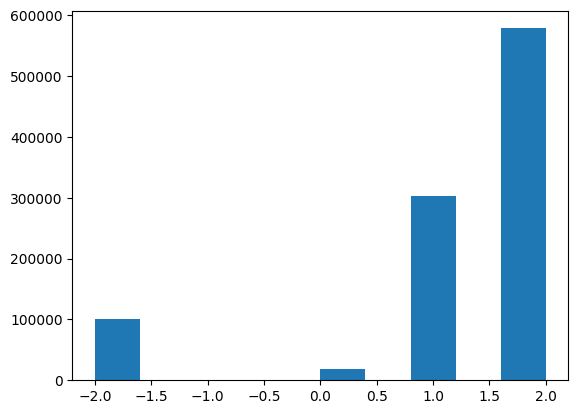

In [28]:
plt.hist(user_item_matrix_synthetic.flatten())

In [29]:
def make_sparse_matrix(user_item_matrix_synthetic, sparsity=0.95):
    mask = np.random.random(user_item_matrix_synthetic.shape) > sparsity

    sparse_matrix = user_item_matrix_synthetic.copy()
    sparse_matrix[~mask] = 0

    return sparse_matrix

(array([4.98700e+03, 4.40000e+01, 9.51053e+05, 4.39160e+04]),
 array([-2., -1.,  0.,  1.,  2.]),
 <BarContainer object of 4 artists>)

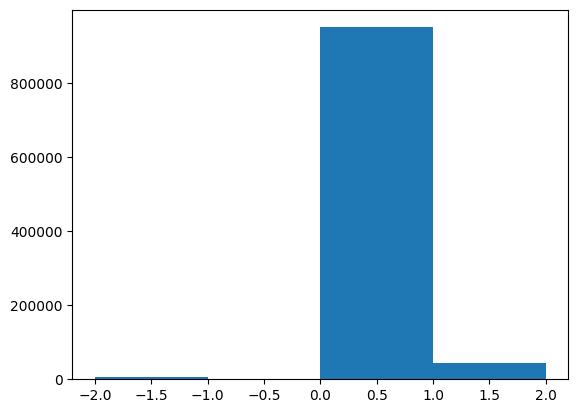

In [30]:
plt.hist(make_sparse_matrix(user_item_matrix_synthetic, sparsity=0.95).flatten(), bins=np.arange(-2, 3, 1))

#### Update loop

In [31]:
# Function to update user latent factors based on revealed ratings
def update_user_latent(user_latent, item_latents, ratings, mask, learning_rate=0.01, regularization=0.01, iterations=50):
    """
    Update a user's latent factors based on known ratings

    Parameters:
    - user_latent: Current user latent factors
    - item_latents: Item latent factors
    - ratings: Full rating vector for the user
    - mask: Boolean mask indicating which ratings are known (True) or unknown (False)

    Returns:
    - Updated user latent factors
    """
    # Copy to avoid modifying the original
    new_user_latent = user_latent.copy()

    # Simple gradient descent to minimize squared error
    for _ in range(iterations):
        # Only use known ratings (where mask is True)
        for i in np.where(mask)[0]:
            prediction = np.dot(new_user_latent, item_latents[i])
            error = ratings[i] - prediction

            # Update user latent factors
            gradient = error * item_latents[i] - regularization * new_user_latent
            new_user_latent += learning_rate * gradient

    return new_user_latent


def run_incremental_learning_experiment(user_item_matrix, n_steps=100, uncertainty_sampling=False,
                                       latent_neighbor=False, n_experiment_users=5, n_factors=20):
    """
    Run an incremental learning experiment simulating cold-start users
    """
    import numpy as np
    from scipy.sparse.linalg import svds
    from sklearn.metrics import mean_squared_error

    # seed
    np.random.seed(42)

    full_user_item_matrix = user_item_matrix.copy()
    user_item_matrix = make_sparse_matrix(user_item_matrix, 0.8)

    # Set up SVD for the entire matrix as a baseline
    U_full, sigma_full, Vt_full = svds(full_user_item_matrix, k=n_factors)
    user_latent_full, item_latents_full = U_full, Vt_full.T

    # Get matrix dimensions
    n_users, n_items = user_item_matrix.shape

    min_rating, max_rating = -2, 2

    # Calculate baseline RMSE with full information
    baseline_predictions = np.dot(user_latent_full, item_latents_full.T)
    baseline_predictions = (baseline_predictions - np.min(baseline_predictions)) / (np.max(baseline_predictions) - np.min(baseline_predictions))
    baseline_predictions = baseline_predictions * (max_rating - min_rating) + min_rating
    baseline_predictions = np.clip(baseline_predictions, -2, 2)

    baseline_rmse = np.sqrt(mean_squared_error(full_user_item_matrix.flatten(),
                                              np.clip(baseline_predictions, -2, 2).flatten()))

    # Track performance metrics across users
    all_rmse_values = []
    all_known_masks = []
    all_baseline_rmse = []

    # Track user indices for reference
    user_indices = []

    for user_run in range(n_experiment_users):
        # Select a random user
        user_idx = np.random.randint(0, n_users)
        user_indices.append(user_idx)
        true_ratings = full_user_item_matrix[user_idx]

        # Create a matrix without this user
        mask = np.ones(n_users, dtype=bool)
        mask[user_idx] = False
        matrix_without_user = user_item_matrix[mask]
        # matrix_without_user = user_item_matrix[mask]

        # Get SVD for matrix without this user
        U_subset, sigma_subset, Vt_subset = svds(matrix_without_user, k=n_factors)
        user_latent_subset, item_latents_subset = U_subset, Vt_subset.T

        # Initialize with average latent factors (cold start)
        current_user_latent = np.mean(user_latent_subset, axis=0)

        # Track which ratings have been revealed
        known_ratings_mask = np.zeros(n_items, dtype=bool)

        # For larger matrices, we'll evaluate on a random subset of items for efficiency
        eval_items = np.random.choice(n_items, size=min(1000, n_items), replace=False)

        # Track performance metrics
        rmse_values = []
        baseline_user_rmse = []

        for step in range(n_steps):
            # Find ratings that haven't been revealed yet
            unrevealed_indices = np.where(~known_ratings_mask)[0]

            if len(unrevealed_indices) == 0:
                break  # All ratings revealed

            # Reveal one rating
            if uncertainty_sampling:
                reveal_idx = active_learning_step(
                    true_ratings,
                    known_ratings_mask,
                    matrix_without_user,
                    user_latent_subset,
                    item_latents_subset,
                    sigma=sigma_subset,
                    n_factors=n_factors,
                    k_neighbors=50,
                    latent_neighbor=latent_neighbor
                )
            else:
                reveal_idx = np.random.choice(unrevealed_indices)

            known_ratings_mask[reveal_idx] = True

            # Update user latent factors based on known ratings
            current_user_latent = update_user_latent(
                current_user_latent,
                item_latents_subset,
                true_ratings,
                known_ratings_mask,
                learning_rate=0.05,
                regularization=0.01,
                iterations=100
            )

            # Predict all ratings
            predicted_ratings = np.dot(current_user_latent, item_latents_subset.T)

            # Normalize and scale predictions
            predicted_ratings = (predicted_ratings - np.min(predicted_ratings)) / (np.max(predicted_ratings) - np.min(predicted_ratings))
            predicted_ratings = predicted_ratings * (max_rating - min_rating) + min_rating

            # Clip predictions to match rating scale
            predicted_ratings = np.clip(predicted_ratings, -2, 2)

            # Calculate RMSE on evaluation items
            rmse = np.sqrt(mean_squared_error(true_ratings[eval_items], predicted_ratings[eval_items]))
            rmse_values.append(rmse)

            baseline_user_rmse.append(baseline_rmse)

        # Store results for this user
        all_rmse_values.append(rmse_values)
        all_known_masks.append(known_ratings_mask)
        all_baseline_rmse.append(baseline_user_rmse)

    return all_rmse_values, all_known_masks, all_baseline_rmse

In [62]:
def plot_results(random_results, uncertainty_results, baselines, file_name: str):
    # Process results for plotting
    def process_results(results):
        max_length = max(len(values) for values in results)
        # Pad shorter arrays with NaN to make them all the same length
        padded_results = np.full((len(results), max_length), np.nan)
        for i, values in enumerate(results):
            padded_results[i, :len(values)] = values
        # Calculate mean and standard deviation
        mean_values = np.nanmean(padded_results, axis=0)
        std_values = np.nanstd(padded_results, axis=0)
        return mean_values, std_values, max_length

    # Process both sets of results
    mean_random, std_random, max_len_random = process_results(random_results)
    mean_uncertainty, std_uncertainty, max_len_uncertainty = process_results(uncertainty_results)

    # Create x-axes for both methods
    x_random = range(1, len(mean_random) + 1)
    x_uncertainty = range(1, len(mean_uncertainty) + 1)

    # Create the plot
    plt.figure(figsize=(12, 7))

    # Plot random selection
    plt.plot(x_random, mean_random, 'b', linewidth=2, label='Random Selection')
    plt.fill_between(x_random, mean_random - std_random, mean_random + std_random,
                     color='b', alpha=0.2)

    # Plot uncertainty sampling
    plt.plot(x_uncertainty, mean_uncertainty, 'orange', linewidth=2, label='Uncertainty Sampling')
    plt.fill_between(x_uncertainty, mean_uncertainty - std_uncertainty, mean_uncertainty + std_uncertainty,
                     color='orange', alpha=0.2)

    # Plot baseline reference
    plt.axhline(y=baselines[0][0], color='r', linestyle='--', linewidth=2,
               label='Baseline (Perfect Information)')

    # Add labels and title
    plt.xlabel('Number of Revealed Ratings', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.title('Comparison of Rating Selection Methods (25 Users)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

    # save plot
    plt.savefig(f'{file_name}.png')

    plt.show()

#### Experiments

In [54]:
# Create/load your synthetic matrix
# SVD on the synthetic matrix
n_factors = 20
U, sigma, Vt = svds(user_item_matrix_synthetic, k=n_factors)
user_latent, item_latents = U, Vt.T

# Run with random selection
print("Running experiment with random selection...")
random_results, random_masks, baselines = run_incremental_learning_experiment(
    user_item_matrix_synthetic,
    n_steps=25,
    uncertainty_sampling=False,
    n_experiment_users=10,
    n_factors=n_factors
)

# Run with uncertainty sampling
print("\nRunning experiment with uncertainty sampling...")
uncertainty_results, uncertainty_masks, _ = run_incremental_learning_experiment(
    user_item_matrix_synthetic,
    n_steps=25,
    uncertainty_sampling=True,
    latent_neighbor=False,
    n_experiment_users=25,
    n_factors=n_factors
)

print("\nRunning experiment with uncertainty sampling and latent neighbors...")
uncertainty_latent_results, uncertainty_latent_masks, _ = run_incremental_learning_experiment(
    user_item_matrix_synthetic,
    n_steps=25,
    uncertainty_sampling=True,
    latent_neighbor=True,
    n_experiment_users=25,
    n_factors=n_factors
)

Running experiment with random selection...

Running experiment with uncertainty sampling...

Running experiment with uncertainty sampling and la|tent neighbors...


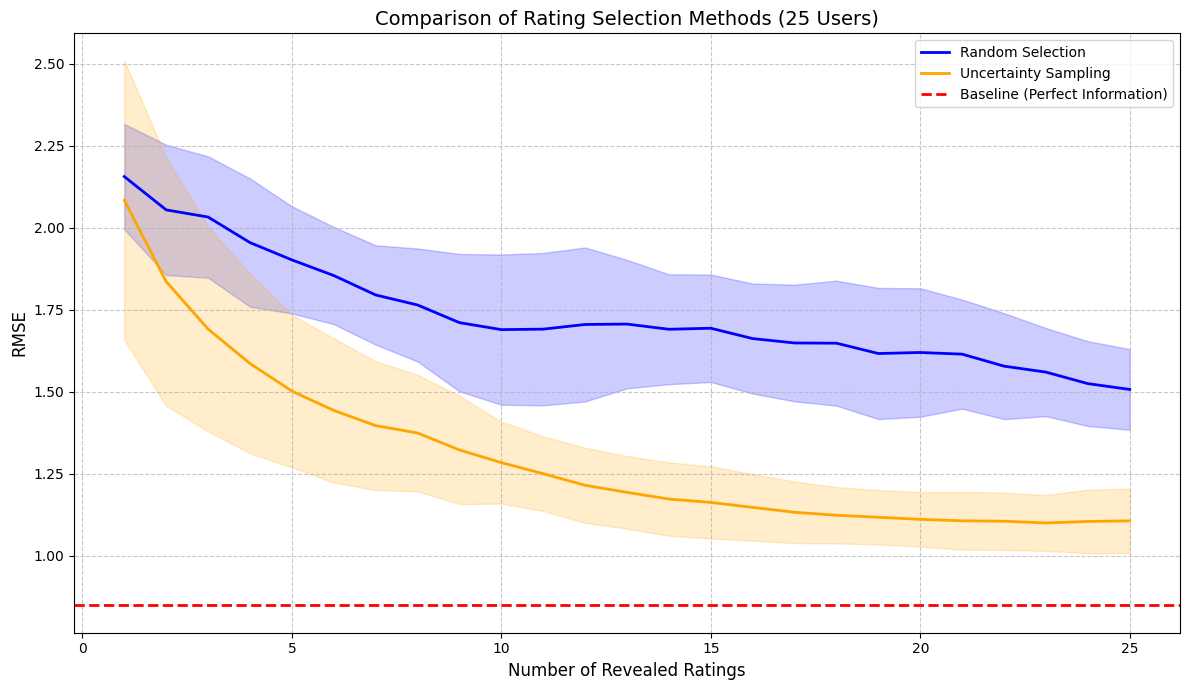

In [63]:
plot_results(random_results, uncertainty_results, baselines, "random_vs_uncertainty")

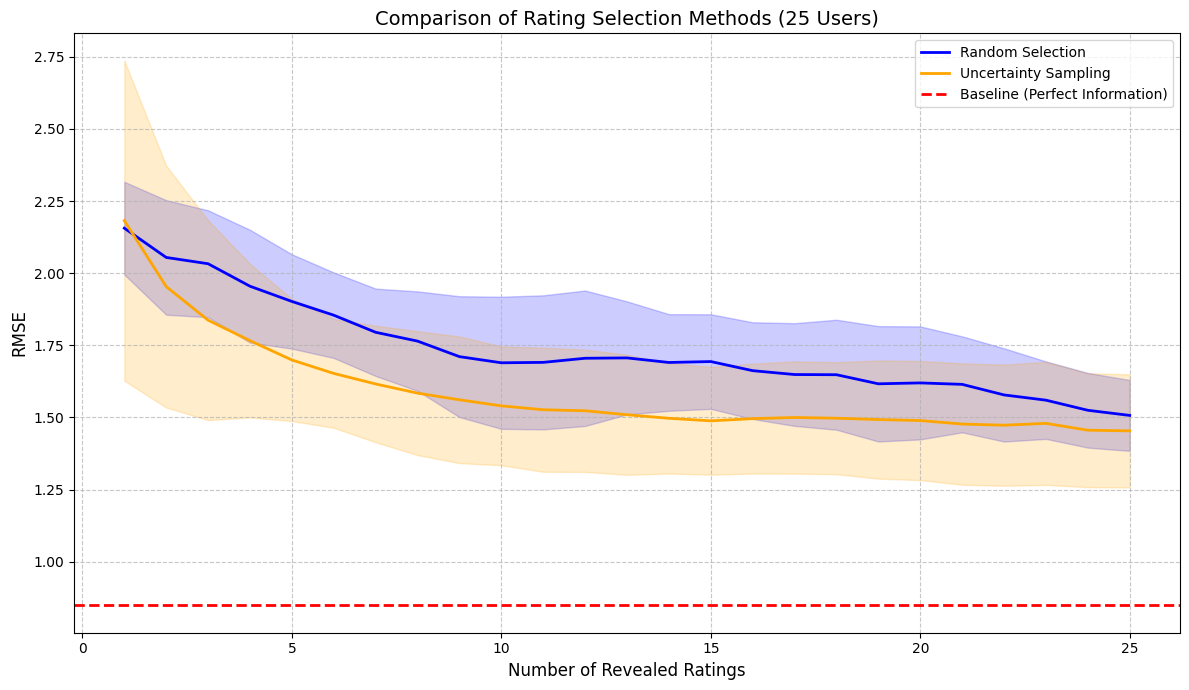

In [64]:
plot_results(random_results, uncertainty_latent_results, baselines, "random_vs_uncertainty_latent")

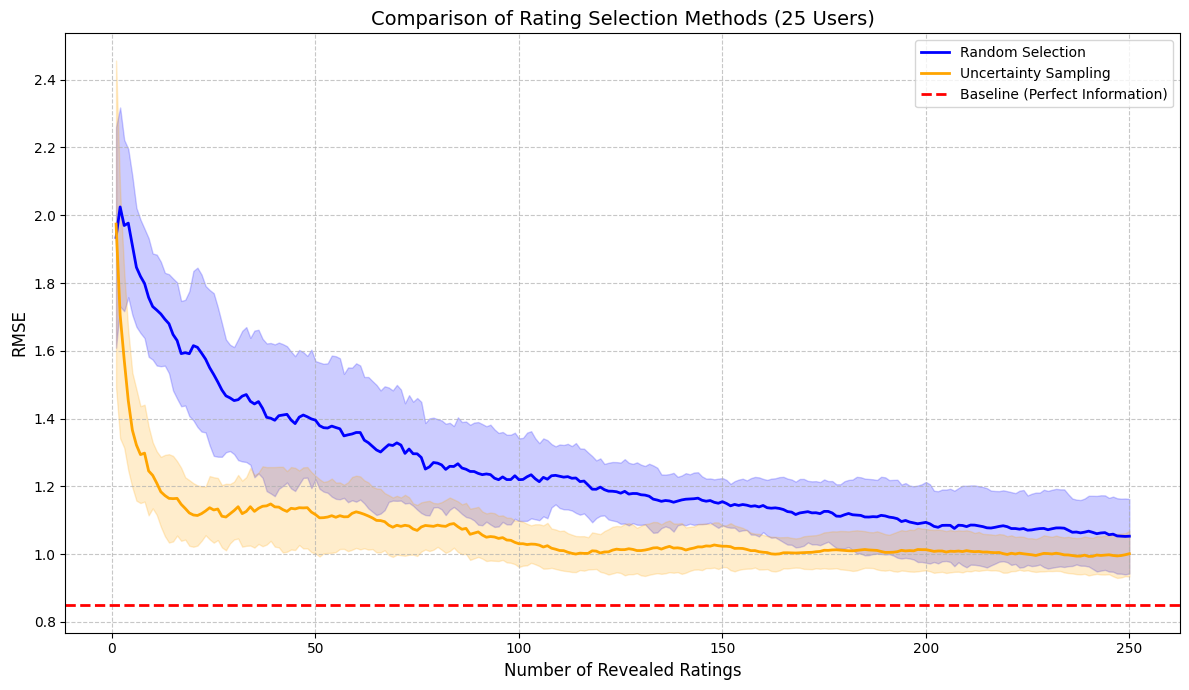

In [277]:
print("Running experiment with random selection...")
random_results_250, _, baselines_250 = run_incremental_learning_experiment(
    user_item_matrix_synthetic,
    n_steps=25,
    uncertainty_sampling=False,
    n_experiment_users=10,
    n_factors=n_factors
)

# Run with uncertainty sampling
print("\nRunning experiment with uncertainty sampling...")
uncertainty_results_250, _, _ = run_incremental_learning_experiment(
    user_item_matrix_synthetic,
    n_steps=25,
    uncertainty_sampling=True,
    latent_neighbor=False,
    n_experiment_users=25,
    n_factors=n_factors
)

In [ ]:
plot_results(random_results_250, uncertainty_results_250, baselines_250, "random_vs_uncertainty_250")